# Langgraph com tools

A ideia é construir um agente que possa utilizar uma tool de busca na internet

# Instanciando modelo e tools

## Criando tool

Iremos usar uma mistura de coisas para fazer a tool de busca na internet.

1 - Vamos usar a Serper para pegar urls que fazem sentido com a busca do usuário.

2-  Iremos usar o playwright para pegar o contexto certo e responder a pergunta

In [1]:
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv(find_dotenv())

serper_api_key = os.getenv("SERPER_API_KEY")

In [2]:
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.tools import tool
from typing import List
from pydantic import BaseModel, Field

class GetAllLinksInput(BaseModel):
    query: str = Field(description="Query que a llm deverá trazer os links associados")

@tool(name_or_callable="get-all-links", args_schema=GetAllLinksInput)
def get_all_links(query: str) -> List[str]: 
    """
    Realiza uma busca na web usando a Google Serper API e extrai uma lista
    dos URLs orgânicos dos resultados.

    Esta função inicializa um wrapper para a Serper API com configurações
    específicas para busca no Brasil e em português, limitando os resultados
    aos 10 principais links orgânicos.

    Args:
        query (str): O termo ou frase de busca a ser usado na Serper API.
                     Exemplo: "notícias de inteligência artificial hoje".

    Returns:
        List[str]: Uma lista de strings, onde cada string é um URL
                   ("link") de um resultado de busca orgânico. A lista
                   conterá no máximo 10 links.

    """
    search_wrapper = GoogleSerperAPIWrapper(
        k=5,
        gl="br",
        hl="pt",
        serper_api_key=serper_api_key
    )   

    results = search_wrapper.results(query=query)
    links = [r["link"] for r in results["organic"]]
    return links


In [3]:
links = get_all_links.invoke({"query":"Classificação brasileirão 2025 hoje"})
links

['https://ge.globo.com/futebol/brasileirao-serie-a/',
 'https://www.espn.com.br/futebol/classificacao/_/liga/bra.1',
 'https://www.cnnbrasil.com.br/esportes/futebol/tabela-do-brasileirao/',
 'https://veja.abril.com.br/campeonatos/brasileirao-serie-a-2025/',
 'https://www.lance.com.br/tabela/brasileirao']

In [4]:
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
import nest_asyncio
nest_asyncio.apply()

async_browser = create_async_playwright_browser()
toolkit = PlayWrightBrowserToolkit(async_browser=async_browser)

In [5]:
playwright_tools = toolkit.get_tools()

In [6]:
tools_by_name = {tool.name: tool for tool in playwright_tools}
navigate_tool = tools_by_name["navigate_browser"]
click_element_tool = tools_by_name["click_element"]
extract_text_tool = tools_by_name["extract_text"]

In [7]:
all_tools = [get_all_links, navigate_tool, click_element_tool, extract_text_tool]

### Instanciando modelo

Aqui eu irei usar os modelos hospedados na plataforma GROQ

In [8]:
from langchain_groq import ChatGroq

model = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct", temperature=0)
model.invoke("Olá")

AIMessage(content='Olá! Como posso ajudar você hoje?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 12, 'total_tokens': 22, 'completion_time': 0.023931071, 'prompt_time': 0.000213677, 'queue_time': 0.460791262, 'total_time': 0.024144748}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--af61482d-20ba-4b5f-ba6e-285acae45750-0', usage_metadata={'input_tokens': 12, 'output_tokens': 10, 'total_tokens': 22})

In [9]:
model_with_tools = model.bind_tools(all_tools)

# Estado do grafo

A ideia aqui é criar uma chave, que irá appendar cada vez que tiver uma mensagem do usuário (HumanMessage) ou da tool (ToolMessage) ou 
da IA (AIMessage). E também pode guardar mensagens do SystemMessage

In [10]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

### Testando o operador add_messages

In [11]:
from langchain_core.messages import HumanMessage, AIMessage
messagens_iniciais = [
    AIMessage(content="Olá, como eu posso te ajudar hoje?"),
    HumanMessage(content="Quero saber quem foi o campeão mundial de clubes em 2005")
]

nova_mensagem = AIMessage(content="O campeão foi o maior time do mundo. O São Paulo FC")

In [12]:
add_messages(left=messagens_iniciais, right=nova_mensagem)

[AIMessage(content='Olá, como eu posso te ajudar hoje?', additional_kwargs={}, response_metadata={}, id='19076f47-23e8-4a64-ae38-6467e82c9285'),
 HumanMessage(content='Quero saber quem foi o campeão mundial de clubes em 2005', additional_kwargs={}, response_metadata={}, id='eaa85976-1dd3-4d1a-b4de-8e85a8c24c50'),
 AIMessage(content='O campeão foi o maior time do mundo. O São Paulo FC', additional_kwargs={}, response_metadata={}, id='82689ac8-1e58-4edb-9005-a63de953d5e5')]

# Criando grafo

### Criando único nó

In [13]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END

# Definir o nó do LLM
def chatbot(state: State):
    return {"messages": [model_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("chatbot", chatbot)

# Criar nó de ferramentas
tool_node = ToolNode(tools=all_tools)
builder.add_node("tools", tool_node)

# Se o modelo pedir uma ferramenta -> ir para "tools"
# Se não -> encerrar
builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Após usar a ferramenta, volta para o LLM
builder.add_edge("tools", "chatbot")

# Definir início
builder.set_entry_point("chatbot")

graph = builder.compile()


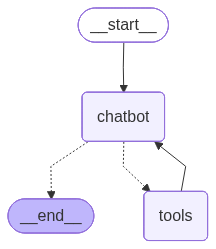

In [14]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
from langchain_core.messages import HumanMessage, SystemMessage

system_message = """
Você é o melhor em buscar informações na internet a partir das funções disponíveis para você.
Use-as da maneira correta e efetiva para que a resposta do usuário seja respondida o mais certo e mais rápido possível
"""

user_input = "Quem é o quinto colocado do campeonato brasileiro hoje??"
state = {
    "messages": [
        SystemMessage(content=system_message),
        HumanMessage(content=user_input)
    ]
}

In [20]:
results = await graph.ainvoke(state)

In [21]:
results

{'messages': [SystemMessage(content='\nVocê é o melhor em buscar informações na internet a partir das funções disponíveis para você.\nUse-as da maneira correta e efetiva para que a resposta do usuário seja respondida o mais certo e mais rápido possível\n', additional_kwargs={}, response_metadata={}, id='0f08715c-a631-45b1-b710-831f53a75dfa'),
  HumanMessage(content='Quem é o quinto colocado do campeonato brasileiro hoje??', additional_kwargs={}, response_metadata={}, id='834942dd-6454-4a49-9407-29134f8425df'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'yqbx0sea9', 'function': {'arguments': '{"query":"classificação do campeonato brasileiro hoje"}', 'name': 'get-all-links'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 985, 'total_tokens': 1014, 'completion_time': 0.065840371, 'prompt_time': 0.030450557, 'queue_time': 0.197035049, 'total_time': 0.096290928}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instr